Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE`, as well as your email used on the [moodle](https://moodle.ens.psl.eu/user/index.php?id=1020) below:

In [1]:
NAME = "GenBill"

---

# Homewrok 1: MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify cloud of points in 2D.

## 1. Some utilities and your dataset

You should not modify the code in this section

In [2]:
# all of these libraries are used for plotting
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import IPython
import math
import os
# from IPython.core.display import display, HTML # my imports
# Plot the dataset
# %matplotlib widget
def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

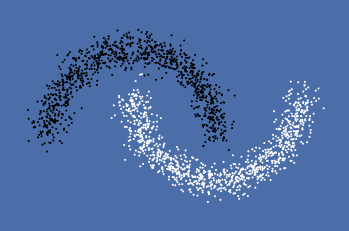

In [4]:
from sklearn.datasets import make_moons
X, Y = make_moons(n_samples=2000, noise=0.1)

# %matplotlib notebook
%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

This is your dataset: two moons each one corresponding to one class (black or white in the picture above).

In order to make it more fun and illustrative, the code below allows you to see the decision boundary of your classifier. Unfortunately, animation is not working on colab...

In [5]:
# plot the decision boundary of our classifier
def plot_decision_boundary(ax, X, Y, classifier):
    # Define the grid on which we will evaluate our classifier
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .01),
                        np.arange(y_min, y_max, .01))

    # the grid for plotting the decision boundary should be now made of tensors.
    # to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))
    to_forward = torch.from_numpy(np.array(list(zip(xx.ravel(), yy.ravel())))).float().to(device)
    # forward pass on the grid, then convert to numpy for plotting
    Z = classifier.forward(to_forward)
    # Z = torch.argmax(Z, dim=1).unsqueeze(1)
    Z = Z.reshape(xx.shape).to('cpu')

    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z>0.5, cmap='Blues')
    
    # then plot the dataset
    plot_data(ax, X, Y)

## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

In [6]:
import torch.nn.functional as F
# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        self.n_input = n_input
        self.n_output = n_output
        self.weight = nn.Parameter(torch.rand(n_input, n_output), requires_grad=True)
        self.bias = nn.Parameter(torch.rand(1, n_output), requires_grad=True)

    def forward(self, x):
        return x @ self.W + self.b
        
class MyReLU_mod(nn.Module):
    def __init__(self, relurate):
        super(MyReLU_mod, self).__init__()
        self.relurate = relurate
        
    def forward(self, x):
        x[x<0] *= self.relurate
        return x


In [7]:
# y = ax^2 + bx + c
class MySquare_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MySquare_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        self.n_input = n_input
        self.n_output = n_output
        self.seight = nn.Parameter(torch.rand(n_input, n_output)/10, requires_grad=True)
        self.weight = nn.Parameter(torch.rand(n_input, n_output), requires_grad=True)
        self.bias = nn.Parameter(torch.rand(1, n_output), requires_grad=True)

    def forward(self, x):
        '''
        print(x.device)
        print(self.a.device)
        print(self.b.device)
        print(self.c.device)
        '''
        return (x*x) @ self.seight + x @ self.weight + self.bias


In [8]:
class MyLoss_mod(nn.Module):
    def __init__(self, lossfunc):
        super(MyLoss_mod, self).__init__()
        self.lossfunc = lossfunc

    def forward(self, x, y):
        Loss_batch = self.lossfunc(x, y)
        # Ret = torch.mean(Loss_batch * Loss_batch)
        return torch.sqrt(torch.mean(Loss_batch * Loss_batch))

In [9]:
# list(MyLinear_mod(2, 3).parameters())
list(MySquare_mod(2, 3).parameters())

[Parameter containing:
 tensor([[0.0558, 0.0737, 0.0966],
         [0.0709, 0.0117, 0.0594]], requires_grad=True),
 Parameter containing:
 tensor([[0.0841, 0.8026, 0.6599],
         [0.8802, 0.5385, 0.9347]], requires_grad=True),
 Parameter containing:
 tensor([[0.5931, 0.4885, 0.4773]], requires_grad=True)]

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [10]:
# h = 50

# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)
'''
net = nn.Sequential(
    MySquare_mod(2, 8),
    MyReLU_mod(),
    MySquare_mod(8, 4),
    MyReLU_mod(),
    MySquare_mod(4, 1),
    # MyLinear_mod(4, 1),
    nn.Sigmoid()
)
'''
# nn.Sequential 没有参数自动转移 device

class MyTemplateNet(nn.Module):
    def __init__(self):
        super(MyTemplateNet, self).__init__() # 第一句话，调用父类的构造函数
        self.squ1 = MySquare_mod(2, 6)
        self.relu1 = MyReLU_mod(-0.1)

        self.squ2 = MySquare_mod(6, 4)
        self.relu2 = MyReLU_mod(-0.2)

        self.squ3 = MySquare_mod(4, 1)

    def forward(self, x):
        # x = self.conv(x)
        # x = self.max_pooling(x)

        # x = x.view(-1, 32 * 6 * 6)
        x = self.squ1(x)
        x = self.relu1(x)
        x = self.squ2(x)
        x = self.relu2(x)
        x = self.squ3(x)
        # x = F.softmax(x,1)
        return x

net = MyTemplateNet().to(device) # 构造模型

if torch.cuda.device_count() > 1: 
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)
net = net.to(device)


In [11]:
lambda_0 = torch.tensor(1.).to(device)
l2_reg = torch.tensor(0.).to(device)
for param in net.parameters():     
    l2_reg += torch.norm(param)
    # print(net.parameters())
for name , p in net.named_parameters():
    print(name)
    print(p)
bias_list = [p for name, p in net.named_parameters() if 'bias' in name]     # (p for name, p in net.named_parameters() if 'bias' in name)
print(bias_list)

squ1.seight
Parameter containing:
tensor([[0.0240, 0.0678, 0.0894, 0.0374, 0.0637, 0.0208],
        [0.0391, 0.0838, 0.0755, 0.0895, 0.0189, 0.0822]], device='cuda:0',
       requires_grad=True)
squ1.weight
Parameter containing:
tensor([[0.8515, 0.6153, 0.0249, 0.5413, 0.0767, 0.1482],
        [0.2145, 0.8394, 0.1919, 0.3384, 0.4417, 0.6754]], device='cuda:0',
       requires_grad=True)
squ1.bias
Parameter containing:
tensor([[0.7248, 0.2461, 0.7022, 0.3568, 0.1761, 0.0959]], device='cuda:0',
       requires_grad=True)
squ2.seight
Parameter containing:
tensor([[0.0534, 0.0550, 0.0764, 0.0608],
        [0.0524, 0.0521, 0.0543, 0.0320],
        [0.0359, 0.0704, 0.0070, 0.0268],
        [0.0900, 0.0834, 0.0077, 0.0844],
        [0.0581, 0.0519, 0.0156, 0.0846],
        [0.0147, 0.0814, 0.0824, 0.0721]], device='cuda:0', requires_grad=True)
squ2.weight
Parameter containing:
tensor([[0.3193, 0.8289, 0.1975, 0.3970],
        [0.1470, 0.0257, 0.1746, 0.6888],
        [0.9155, 0.2981, 0.4367, 

In [20]:
from torch import optim
import random

X_torch = torch.from_numpy(X).float().to(device)
Y_torch = torch.from_numpy(Y).unsqueeze(1).float().to(device)

# optimizer = optim.Adam(params=net.parameters(), lr=1e-4, momentum=0.9)
# optimizer = optim.SGD((p for name, p in net.named_parameters() if 'bias' in name), lr=1e-3, momentum=0.9, weight_decay=0.)
optimizer = optim.SGD(
    [
        {'params': (p for name, p in net.named_parameters() if 'seight' in name), 'lr': 3e-3, 'momentum': 0.4, 'weight_decay': 1e-3},
        {'params': (p for name, p in net.named_parameters() if 'weight' in name), 'lr': 6e-3, 'momentum': 0.6, 'weight_decay': 1e-4},
        {'params': (p for name, p in net.named_parameters() if 'bias' in name), 'lr': 1e-2, 'momentum': 0.9, 'weight_decay': 0.}
    ]   # , lr=1e-3, momentum=0.8, weight_decay=0.001
)

criterion = MyLoss_mod(nn.BCEWithLogitsLoss(reduction='none'))          # 可以处理NAN的情况，但结果没有意义
# criterion = MyLoss_mod(nn.BCELoss(reduction='none'))                  # 当出现pred爆炸时会触发cuda错误
# criterion = nn.BCEWithLogitsLoss()

sample_size = len(X_torch)
batch_size = 64
epoch_num = 200
losses = []

In [22]:
optimizer = optim.SGD(
    [
        {'params': (p for name, p in net.named_parameters() if 'seight' in name), 'lr': 1e-6, 'momentum': 0.4, 'weight_decay': 1e-3},
        {'params': (p for name, p in net.named_parameters() if 'weight' in name), 'lr': 1e-5, 'momentum': 0.6, 'weight_decay': 1e-4},
        {'params': (p for name, p in net.named_parameters() if 'bias' in name), 'lr': 1e-4, 'momentum': 0.9, 'weight_decay': 0.}
    ]   # , lr=1e-3, momentum=0.8, weight_decay=0.001
)

In [27]:
optimizer = optim.SGD(
    [
        {'params': (p for name, p in net.named_parameters() if 'seight' in name), 'lr': 1e-8, 'momentum': 0.2, 'weight_decay': 1e-3},
        {'params': (p for name, p in net.named_parameters() if 'weight' in name), 'lr': 1e-6, 'momentum': 0.4, 'weight_decay': 1e-4},
        {'params': (p for name, p in net.named_parameters() if 'bias' in name), 'lr': 1e-4, 'momentum': 0.6, 'weight_decay': 0.}
    ]   # , lr=1e-3, momentum=0.8, weight_decay=0.001
)

Epoch: 0 , loss: 0.000850246986374259 , acc_rate: 0.9915
Epoch: 10 , loss: 0.01151027251034975 , acc_rate: 0.9915
Epoch: 20 , loss: 6.99983283993788e-05 , acc_rate: 0.9915
Epoch: 30 , loss: 0.0013828703667968512 , acc_rate: 0.9915
Epoch: 40 , loss: 0.0032771688420325518 , acc_rate: 0.9915
Epoch: 50 , loss: 0.00025102109066210687 , acc_rate: 0.9915
Epoch: 60 , loss: 0.004475174006074667 , acc_rate: 0.9915
Epoch: 70 , loss: 0.0003783438296522945 , acc_rate: 0.9915
Epoch: 80 , loss: 0.0014517400413751602 , acc_rate: 0.9915
Epoch: 90 , loss: 0.0005480911931954324 , acc_rate: 0.9915
Epoch: 100 , loss: 0.00039936875691637397 , acc_rate: 0.9915
Epoch: 110 , loss: 0.003672344144433737 , acc_rate: 0.9915
Epoch: 120 , loss: 0.06137368083000183 , acc_rate: 0.9915
Epoch: 130 , loss: 0.0004699630371760577 , acc_rate: 0.9915
Epoch: 140 , loss: 0.0014165297616273165 , acc_rate: 0.9915
Epoch: 150 , loss: 0.0005755226011388004 , acc_rate: 0.9915
Epoch: 160 , loss: 0.0010637037921696901 , acc_rate: 0.99

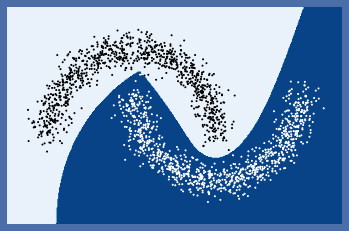

In [28]:
for epoch in range(epoch_num):
    rand_index = random.sample(range(0,sample_size), sample_size)
    it_max = sample_size//batch_size
    acc = 0
    for it in range(it_max):
        # pick a random example id 
        j = it * batch_size
        # select the corresponding example and label
        if j+batch_size <= sample_size:
            example = X_torch[rand_index[j:j+batch_size]]
            label = Y_torch[rand_index[j:j+batch_size]]
        else:
            example = X_torch[rand_index[j:]]
            label = Y_torch[rand_index[j:]]
        # do a forward pass on the example
        pred = net(example)
        # print(pred, label)
        # compute the loss according to your output and the label
        loss = criterion(pred, label)

        losses.append(loss.item())
        isCorrect = ((pred>0.5)==label)
        # isCorrect = torch.argmax(pred, dim=1)==torch.argmax(label, dim=1)
        acc += torch.sum(isCorrect).item()
        
        # zero the gradients
        optimizer.zero_grad()
        # backward pass
        loss.backward()
        # gradient step
        optimizer.step()
    if epoch % 10 == 0:
        print('Epoch:', epoch, ', loss:', loss.item(), ', acc_rate:', acc/sample_size)

# you should comment the following line if on colab
# %matplotlib notebook
# %matplotlib inline
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, net)
# fig.canvas.draw()
# print('Final loss:', loss.item())

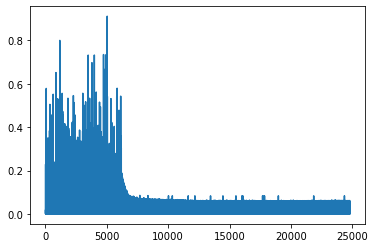

In [29]:
%matplotlib inline
plt.plot(losses)